In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from pandas import DataFrame , concat
from sklearn.metrics import mean_absolute_error , mean_squared_error
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from numpy import mean , concatenate
from math import sqrt
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Activation,Dropout
from tensorflow.keras.optimizers import Adam
from numpy import array , hstack
from tensorflow import keras
import tensorflow as tf

In [12]:
df = pd.read_csv('d1_with_status_new.csv')
df

,Date,z1_AC1(kW),z1_S1(degC),Status
0,2018-07-01 00:00:00,0.0,27.57,0.0
1,2018-07-01 00:01:00,0.0,27.57,0.0
2,2018-07-01 00:02:00,0.0,27.57,0.0
3,2018-07-01 00:03:00,0.0,27.56,0.0
4,2018-07-01 00:04:00,0.0,27.56,0.0
...,...,...,...,...
101116,2018-09-13 03:42:00,0.0,26.86,0.0
101117,2018-09-13 03:43:00,0.0,26.86,0.0
101118,2018-09-13 03:44:00,0.0,26.86,0.0
101119,2018-09-13 03:45:00,0.0,26.86,0.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101121 entries, 0 to 101120
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         101121 non-null  object 
 1   z1_AC1(kW)   101121 non-null  float64
 2   z1_S1(degC)  101121 non-null  float64
 3   Status       101121 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.1+ MB


<AxesSubplot:>

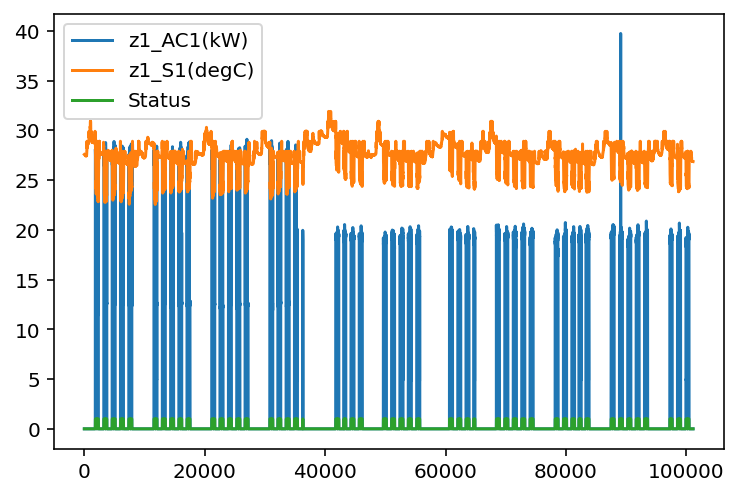

In [14]:
df.plot()

In [15]:
df['Status'].value_counts()

0.0    80148
1.0    20973
Name: Status, dtype: int64

In [16]:
df.index = pd.to_datetime(df['Date'], format='%Y.%m.%d %H:%M:%S')
df.drop(['Date'], inplace= True, axis=1)
df[:26]

,z1_AC1(kW),z1_S1(degC),Status
Date,,,
2018-07-01 00:00:00,0.0,27.57,0.0
2018-07-01 00:01:00,0.0,27.57,0.0
2018-07-01 00:02:00,0.0,27.57,0.0
2018-07-01 00:03:00,0.0,27.56,0.0
2018-07-01 00:04:00,0.0,27.56,0.0
2018-07-01 00:05:00,0.0,27.56,0.0
2018-07-01 00:06:00,0.0,27.56,0.0
2018-07-01 00:07:00,0.0,27.56,0.0
2018-07-01 00:08:00,0.0,27.56,0.0


In [17]:
values = df.values

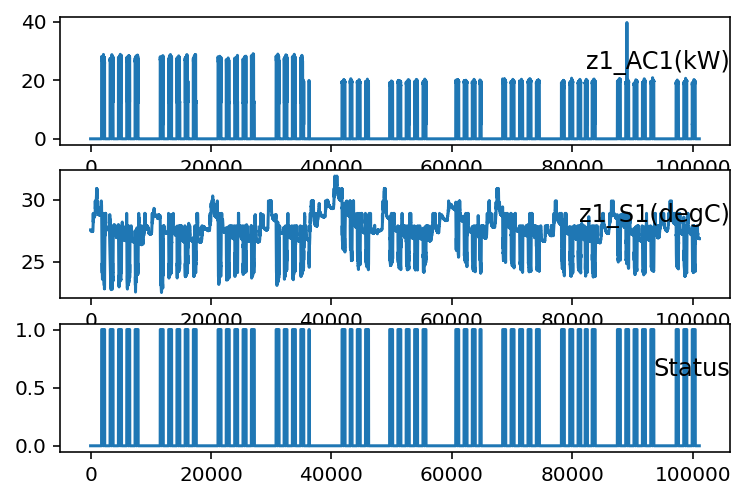

In [63]:
from matplotlib import pyplot
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [19]:
test_split=round(len(df)*0.30)

In [20]:
test_split

30336

In [21]:
df_for_training=df[:-30336]
df_for_testing=df[-30336:]

In [22]:
print(df_for_training.shape)
print(df_for_testing.shape)

(70785, 3)
(30336, 3)


In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [24]:
df_for_testing_scaled=scaler.transform(df_for_testing)

In [25]:
df_for_training_scaled

array([[0.        , 0.5368984 , 0.        ],
       [0.        , 0.5368984 , 0.        ],
       [0.        , 0.5368984 , 0.        ],
       ...,
       [0.        , 0.53368984, 0.        ],
       [0.        , 0.53368984, 0.        ],
       [0.        , 0.53262032, 0.        ]])

In [26]:
df_for_training_scaled.shape , df_for_testing_scaled.shape

((70785, 3), (30336, 3))

In [27]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,1])
    return np.array(dataX),np.array(dataY)

In [28]:
trainX,trainY=createXY(df_for_training_scaled,15)

In [29]:
trainX.shape

(70770, 15, 3)

In [30]:
testX,testY=createXY(df_for_testing_scaled,15)

In [31]:
trainX[0]

array([[0.        , 0.5368984 , 0.        ],
       [0.        , 0.5368984 , 0.        ],
       [0.        , 0.5368984 , 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ],
       [0.        , 0.53582888, 0.        ]])

In [32]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (70770, 15, 3)
trainY Shape--  (70770,)


In [33]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (30321, 15, 3)
testY Shape--  (30321,)


In [34]:
print("trainX[0]-- \n",trainX[0])
print("\ntrainY[0]-- ",trainY[0])

trainX[0]-- 
 [[0.         0.5368984  0.        ]
 [0.         0.5368984  0.        ]
 [0.         0.5368984  0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]
 [0.         0.53582888 0.        ]]

trainY[0]--  0.5358288770053474


In [35]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [38]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(15,3)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.3))
    grid_model.add(Dense(1))

    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
parameters = {'batch_size' : [10,20,30],
              'epochs' : [10,20,50],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 2)

In [39]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/10
3539/3539 [==============================] - 47s 12ms/step - loss: 0.0028 - val_loss: 2.0500e-04
Epoch 2/10
3539/3539 [==============================] - 41s 12ms/step - loss: 5.8179e-04 - val_loss: 6.1100e-04
Epoch 3/10
3539/3539 [==============================] - 38s 11ms/step - loss: 4.3077e-04 - val_loss: 1.4064e-04
Epoch 4/10
3539/3539 [==============================] - 43s 12ms/step - loss: 3.9240e-04 - val_loss: 1.6625e-04
Epoch 5/10
3539/3539 [==============================] - 36s 10ms/step - loss: 3.6841e-04 - val_loss: 8.4872e-05
Epoch 6/10
3539/3539 [==============================] - 40s 11ms/step - loss: 3.6064e-04 - val_loss: 9.3248e-05
Epoch 7/10
3539/3539 [==============================] - 42s 12ms/step - loss: 3.5239e-04 - val_loss: 9.2626e-05
Epoch 8/10
3539/3539 [==============================] - 38s 11ms/step - loss: 3.4450e-04 - val_loss: 1.3194e-04
Epoch 9/10
3539/3539 [==============================] - 37s 10ms/step - loss: 3.4229e-04 - val_loss: 9.5158e

3539/3539 [==============================] - 42s 12ms/step - loss: 3.2399e-04 - val_loss: 9.8391e-05
Epoch 24/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.1684e-04 - val_loss: 8.9092e-05
Epoch 25/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.1849e-04 - val_loss: 1.2530e-04
Epoch 26/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.1931e-04 - val_loss: 9.7125e-05
Epoch 27/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.1843e-04 - val_loss: 1.2047e-04
Epoch 28/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.2045e-04 - val_loss: 1.2103e-04
Epoch 29/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.2134e-04 - val_loss: 1.0206e-04
Epoch 30/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.1587e-04 - val_loss: 9.4398e-05
Epoch 31/50
3539/3539 [==============================] - 42s 12ms/step - loss: 3.2025e-04 - val_loss: 1.9412

3539/3539 [==============================] - 43s 12ms/step - loss: 3.6486e-04 - val_loss: 8.5331e-05
Epoch 46/50
3539/3539 [==============================] - 41s 12ms/step - loss: 3.6295e-04 - val_loss: 8.5241e-05
Epoch 47/50
3539/3539 [==============================] - 36s 10ms/step - loss: 3.5730e-04 - val_loss: 9.4940e-05
Epoch 48/50
3539/3539 [==============================] - 37s 10ms/step - loss: 3.6399e-04 - val_loss: 9.3252e-05
Epoch 49/50
3539/3539 [==============================] - 36s 10ms/step - loss: 3.6536e-04 - val_loss: 8.9766e-05
Epoch 50/50
3539/3539 [==============================] - 15s 4ms/step - loss: 1.0192e-04
Epoch 1/50
3539/3539 [==============================] - 45s 12ms/step - loss: 0.2281 - val_loss: 0.0119
Epoch 2/50
3539/3539 [==============================] - 43s 12ms/step - loss: 0.0110 - val_loss: 0.0011
Epoch 3/50
3539/3539 [==============================] - 43s 12ms/step - loss: 0.0084 - val_loss: 9.6933e-04
Epoch 4/50
3539/3539 [====================

Epoch 19/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0037 - val_loss: 4.4054e-04
Epoch 20/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0036 - val_loss: 4.4262e-04
Epoch 21/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0036 - val_loss: 4.2718e-04
Epoch 22/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0035 - val_loss: 4.2034e-04
Epoch 23/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0034 - val_loss: 4.2066e-04
Epoch 24/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0034 - val_loss: 4.2079e-04
Epoch 25/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0033 - val_loss: 4.1766e-04
Epoch 26/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0033 - val_loss: 4.1075e-04
Epoch 27/50
3539/3539 [==============================] - 42s 12ms/step - loss: 0.0032 - val_loss: 4.1091e-04
Epoch 28/50
3539/35

Epoch 13/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0053 - val_loss: 8.2753e-04
Epoch 14/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0051 - val_loss: 7.9888e-04
Epoch 15/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0050 - val_loss: 7.4785e-04
Epoch 16/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0048 - val_loss: 7.1225e-04
Epoch 17/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0047 - val_loss: 6.8898e-04
Epoch 18/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0045 - val_loss: 6.4783e-04
Epoch 19/20
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0044 - val_loss: 6.3624e-04
Epoch 20/20
1770/1770 [==============================] - 8s 4ms/step - loss: 0.0017
Epoch 1/50
1770/1770 [==============================] - 25s 13ms/step - loss: 0.0040 - val_loss: 4.3997e-04
Epoch 2/50
1770/1770 [=======================

1770/1770 [==============================] - 23s 13ms/step - loss: 0.0040 - val_loss: 3.6546e-04
Epoch 38/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0040 - val_loss: 3.5622e-04
Epoch 39/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0039 - val_loss: 3.5787e-04
Epoch 40/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0039 - val_loss: 3.5916e-04
Epoch 41/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0038 - val_loss: 3.5897e-04
Epoch 42/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0038 - val_loss: 3.5587e-04
Epoch 43/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0039 - val_loss: 3.5447e-04
Epoch 44/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0037 - val_loss: 3.5546e-04
Epoch 45/50
1770/1770 [==============================] - 23s 13ms/step - loss: 0.0037 - val_loss: 3.5899e-04
Epoch 46/50
1770/1770 [========

1180/1180 [==============================] - 4s 3ms/step - loss: 1.7101e-04
Epoch 1/10
1180/1180 [==============================] - 12s 9ms/step - loss: 0.0032 - val_loss: 3.1948e-04
Epoch 2/10
1180/1180 [==============================] - 10s 9ms/step - loss: 0.0012 - val_loss: 2.1916e-04
Epoch 3/10
1180/1180 [==============================] - 12s 10ms/step - loss: 6.6651e-04 - val_loss: 1.7170e-04
Epoch 4/10
1180/1180 [==============================] - 10s 9ms/step - loss: 4.9903e-04 - val_loss: 2.0798e-04
Epoch 5/10
1180/1180 [==============================] - 12s 10ms/step - loss: 4.5847e-04 - val_loss: 1.4059e-04
Epoch 6/10
1180/1180 [==============================] - 12s 10ms/step - loss: 4.4075e-04 - val_loss: 1.5355e-04
Epoch 7/10
1180/1180 [==============================] - 13s 11ms/step - loss: 4.2905e-04 - val_loss: 1.4369e-04
Epoch 8/10
1180/1180 [==============================] - 12s 10ms/step - loss: 4.1346e-04 - val_loss: 1.8116e-04
Epoch 9/10
1180/1180 [=================

1180/1180 [==============================] - 12s 10ms/step - loss: 3.0929e-04 - val_loss: 1.4726e-04
Epoch 35/50
1180/1180 [==============================] - 12s 10ms/step - loss: 3.1624e-04 - val_loss: 1.0806e-04
Epoch 36/50
1180/1180 [==============================] - 14s 12ms/step - loss: 3.0338e-04 - val_loss: 9.0397e-05
Epoch 37/50
1180/1180 [==============================] - 12s 10ms/step - loss: 3.0881e-04 - val_loss: 9.4781e-05
Epoch 38/50
1180/1180 [==============================] - 13s 11ms/step - loss: 3.0694e-04 - val_loss: 1.2352e-04
Epoch 39/50
1180/1180 [==============================] - 13s 11ms/step - loss: 3.1840e-04 - val_loss: 8.5514e-05
Epoch 40/50
1180/1180 [==============================] - 13s 11ms/step - loss: 3.0700e-04 - val_loss: 1.8407e-04
Epoch 41/50
1180/1180 [==============================] - 11s 9ms/step - loss: 3.1554e-04 - val_loss: 8.5373e-05
Epoch 42/50
1180/1180 [==============================] - 14s 12ms/step - loss: 3.0656e-04 - val_loss: 9.1383e

Epoch 6/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0090 - val_loss: 6.7103e-04
Epoch 7/50
1180/1180 [==============================] - 12s 11ms/step - loss: 0.0087 - val_loss: 6.6148e-04
Epoch 8/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0083 - val_loss: 6.3362e-04
Epoch 9/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0080 - val_loss: 6.2401e-04
Epoch 10/50
1180/1180 [==============================] - 11s 9ms/step - loss: 0.0078 - val_loss: 5.9773e-04
Epoch 11/50
1180/1180 [==============================] - 11s 10ms/step - loss: 0.0075 - val_loss: 5.7337e-04
Epoch 12/50
1180/1180 [==============================] - 11s 9ms/step - loss: 0.0072 - val_loss: 5.6985e-04
Epoch 13/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0070 - val_loss: 5.3371e-04
Epoch 14/50
1180/1180 [==============================] - 14s 12ms/step - loss: 0.0068 - val_loss: 5.2002e-04
Epoch 15/50
1180/1180 [==

Epoch 31/50
1180/1180 [==============================] - 14s 12ms/step - loss: 0.0041 - val_loss: 5.7604e-04
Epoch 32/50
1180/1180 [==============================] - 12s 10ms/step - loss: 0.0040 - val_loss: 5.5696e-04
Epoch 33/50
1180/1180 [==============================] - 14s 12ms/step - loss: 0.0039 - val_loss: 5.5674e-04
Epoch 34/50
1180/1180 [==============================] - 14s 12ms/step - loss: 0.0039 - val_loss: 5.3055e-04
Epoch 35/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0038 - val_loss: 5.4132e-04
Epoch 36/50
1180/1180 [==============================] - 14s 11ms/step - loss: 0.0038 - val_loss: 5.2243e-04
Epoch 37/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0037 - val_loss: 5.3025e-04
Epoch 38/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0038 - val_loss: 5.0140e-04
Epoch 39/50
1180/1180 [==============================] - 13s 11ms/step - loss: 0.0037 - val_loss: 4.9788e-04
Epoch 40/50
1180/11

In [40]:
grid_search.best_params_

{'batch_size': 30, 'epochs': 50, 'optimizer': 'adam'}

In [41]:
my_model=grid_search.best_estimator_.model

In [42]:
my_model

In [49]:
my_model.history.history

{'loss': [0.0025478312745690346,
  0.0006212838343344629,
  0.0004604878486134112,
  0.00042004877468571067,
  0.00040032618562690914,
  0.00037934063584543765,
  0.0003812390787061304,
  0.0003733938792720437,
  0.00037163711385801435,
  0.00037354169762693346,
  0.0003712257312145084,
  0.00036446229205466807,
  0.0003637159534264356,
  0.0003620204224716872,
  0.0003602108627092093,
  0.0003686895070131868,
  0.0003586663515307009,
  0.00036258483305573463,
  0.00036105141043663025,
  0.00035560387186706066,
  0.00035835313610732555,
  0.0003554731956683099,
  0.0003600224736146629,
  0.0003593370784074068,
  0.0003516954311635345,
  0.0003540767647791654,
  0.00035718860453926027,
  0.000355973606929183,
  0.0003556873125489801,
  0.0003523687773849815,
  0.000354582880390808,
  0.00035022731753997505,
  0.00034515108563937247,
  0.0003566825471352786,
  0.0003509510133881122,
  0.0003546500811353326,
  0.0003509902162477374,
  0.00035764058702625334,
  0.0003486557397991419,
  0.0

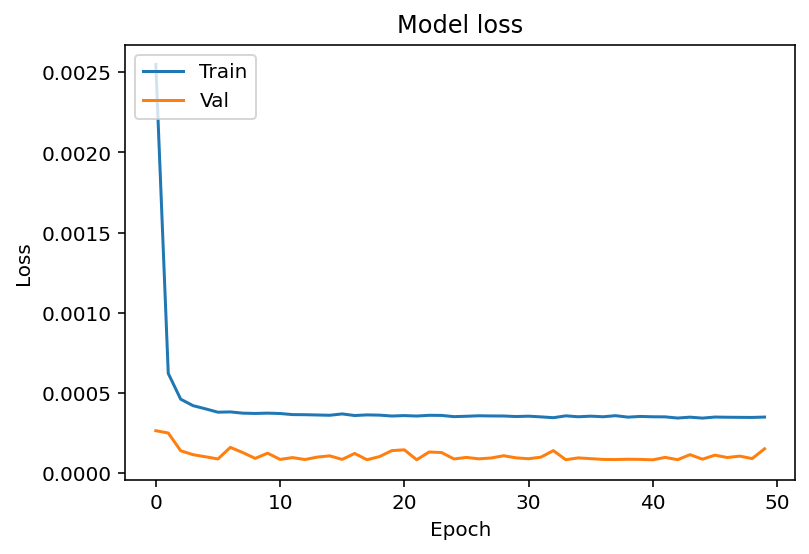

In [51]:
plt.plot(range(len(my_model.history.history['loss'])), my_model.history.history['loss'])
plt.plot(range(len(my_model.history.history['val_loss'])), my_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'], loc='upper left')
plt.show()

In [52]:
prediction=my_model.predict(testX)

In [53]:
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[0.53501755]
 [0.53496593]
 [0.53499186]
 ...
 [0.46709126]
 [0.46709126]
 [0.46709126]]

Prediction Shape- (30321, 1)


In [54]:
scaler.inverse_transform(prediction)

ValueError: non-broadcastable output operand with shape (30321,1) doesn't match the broadcast shape (30321,3)

In [55]:
prediction_copies_array = np.repeat(prediction,3, axis=-1)

In [56]:
prediction_copies_array.shape

(30321, 3)

In [57]:
prediction_copies_array

array([[0.53501755, 0.53501755, 0.53501755],
       [0.53496593, 0.53496593, 0.53496593],
       [0.53499186, 0.53499186, 0.53499186],
       ...,
       [0.46709126, 0.46709126, 0.46709126],
       [0.46709126, 0.46709126, 0.46709126],
       [0.46709126, 0.46709126, 0.46709126]], dtype=float32)

In [58]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),3)))[:,1]

In [59]:
pred

array([27.552416, 27.551931, 27.552174, ..., 26.917303, 26.917303,
       26.917303], dtype=float32)

In [60]:
original_copies_array = np.repeat(testY,3, axis=-1)

original_copies_array.shape

original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),3)))[:,1]

In [61]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- ",original)

Pred Values--  [27.552416 27.551931 27.552174 ... 26.917303 26.917303 26.917303]

Original Values--  [27.52 27.52 27.52 ... 26.86 26.86 26.86]


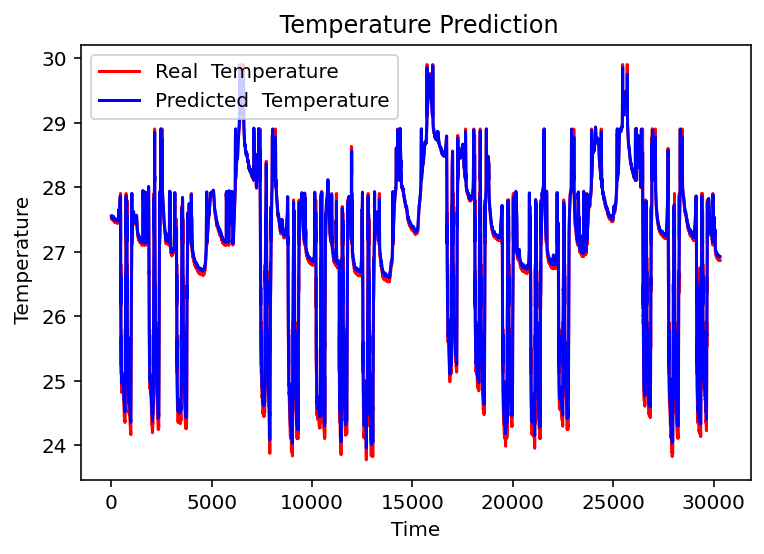

In [62]:
plt.plot(original, color = 'red', label = 'Real  Temperature')
plt.plot(pred, color = 'blue', label = 'Predicted  Temperature')
plt.title(' Temperature Prediction')
plt.xlabel('Time')
plt.ylabel(' Temperature')
plt.legend()
plt.show()

In [67]:
pred_df = pd.DataFrame(pred, columns=['Predicted Temperature'])

In [68]:
pred_df

,Predicted Temperature
0,27.552416
1,27.551931
2,27.552174
3,27.552128
4,27.552725
...,...
30316,26.917303
30317,26.917303
30318,26.917303
30319,26.917303


In [70]:
actual_df = pd.DataFrame(original, columns=['Original Temperature'])

In [71]:
actual_df

,Original Temperature
0,27.52
1,27.52
2,27.52
3,27.52
4,27.52
...,...
30316,26.86
30317,26.86
30318,26.86
30319,26.86


In [74]:
result = pd.concat([pred_df, actual_df], axis=1, join='inner')
result

,Predicted Temperature,Original Temperature
0,27.552416,27.52
1,27.551931,27.52
2,27.552174,27.52
3,27.552128,27.52
4,27.552725,27.52
...,...,...
30316,26.917303,26.86
30317,26.917303,26.86
30318,26.917303,26.86
30319,26.917303,26.86


In [75]:
status_df = pd.read_csv('new_test.csv')

In [76]:
status_df

,Status
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
30316,0.0
30317,0.0
30318,0.0
30319,0.0


In [77]:
result1 = pd.concat([result, status_df], axis=1, join='inner')

In [78]:
result1

,Predicted Temperature,Original Temperature,Status
0,27.552416,27.52,0.0
1,27.551931,27.52,0.0
2,27.552174,27.52,0.0
3,27.552128,27.52,0.0
4,27.552725,27.52,0.0
...,...,...,...
30316,26.917303,26.86,0.0
30317,26.917303,26.86,0.0
30318,26.917303,26.86,0.0
30319,26.917303,26.86,0.0


In [81]:
result1['Status Mode'] = 'NaN'

for i in range(len(result1)):
    if result1['Status'][i] == 0:
        result1['Status Mode'][i]="Off"
        
    else: result1['Status Mode'][i]="On"

C:\Users\azhan\anaconda3\envs\FYP\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\azhan\anaconda3\envs\FYP\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [82]:
result1

,Predicted Temperature,Original Temperature,Status,Status Mode
0,27.552416,27.52,0.0,Off
1,27.551931,27.52,0.0,Off
2,27.552174,27.52,0.0,Off
3,27.552128,27.52,0.0,Off
4,27.552725,27.52,0.0,Off
...,...,...,...,...
30316,26.917303,26.86,0.0,Off
30317,26.917303,26.86,0.0,Off
30318,26.917303,26.86,0.0,Off
30319,26.917303,26.86,0.0,Off


In [85]:
result1['Status Mode'].value_counts()

Off    23628
On      6693
Name: Status Mode, dtype: int64